In [2]:
# pip install yfinance
# pip install prophet
# pip install cmdstanpy prophet

In [ ]:
# !pip install --upgrade prophet
# !pip install cmdstanpy
# !python -m prophet.install_cmdstan

In [23]:
# pip uninstall fbprophet prophet pystan -y

In [22]:
# pip install pandas==2.0.3

In [ ]:
# pip uninstall prophet -y

Found existing installation: prophet 1.3.0
Uninstalling prophet-1.3.0:
  Successfully uninstalled prophet-1.3.0
Note: you may need to restart the kernel to use updated packages.


In [4]:
# pip install prophet cmdstanpy --no-cache-dir

In [1]:
import yfinance as yf
import pandas as pd

# Example: Pull Apple (AAPL) stock data
ticker = "AAPL"

# Download historical data (daily, last 1 year)
data = yf.download(ticker, period="1y", interval="1d")

[*********************100%***********************]  1 of 1 completed


In [2]:
print(pd.__version__)

2.0.3


In [3]:
data.head()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2025-01-31,234.937439,246.077060,232.388967,246.077060,100959800
2025-02-03,226.983414,230.786222,224.683817,228.954510,73063300
2025-02-04,231.751862,232.080378,225.629542,226.226846,45067300
2025-02-05,231.423340,231.622436,227.242253,227.501077,39620300
2025-02-06,232.169952,232.747343,229.392506,230.248634,29925300


In [4]:
tickers = ["AAPL", "MSFT", "GOOG"]
data_multi = yf.download(tickers, period="10y", interval="1d")

data_multi.head()

[*********************100%***********************]  3 of 3 completed


Price           Close                             High                        \
Ticker           AAPL       GOOG       MSFT       AAPL       GOOG       MSFT   
Date                                                                           
2016-02-01  21.741970  37.320091  47.904659  21.805101  37.610913  48.237392   
2016-02-02  21.302311  37.947884  46.407356  21.654042  39.199498  47.510624   
2016-02-03  21.723930  36.076916  45.671841  21.834410  38.436715  46.748841   
2016-02-04  21.898476  35.136963  45.531742  22.063962  36.079392  46.240988   
2016-02-05  21.313620  33.924061  43.920628  21.971028  34.937460  45.531751   

Price             Low                             Open                        \
Ticker           AAPL       GOOG       MSFT       AAPL       GOOG       MSFT   
Date                                                                           
2016-02-01  21.509737  36.886844  47.720782  21.750989  37.243665  48.053515   
2016-02-02  21.257216  37.947884  46.100894  21.514251  38.932995  47.431819   
2016-02-03  21.212117  35.756818  44.883790  21.419548  38.224312  46.626256   
2016-02-04  21.578840  34.831749  44.980107  21.730724  35.871452  45.619302   
2016-02-05  21.238812  33.754332  43.395263  21.880351  34.931504  45.479213   

Price          Volume                       
Ticker           AAPL       GOOG      MSFT  
Date                                        
2016-02-01  163774000  102784000  44208500  
2016-02-02  149428800  126962000  56313800  
2016-02-03  183857200  123420000  57559800  
2016-02-04  185886800  103374000  46987100  
2016-02-05  185672400  102114000  62009000

In [5]:
import numpy as np

In [6]:
df = data_multi.unstack().reset_index()

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
df.head()

,Price,Ticker,Date,0
0,Close,AAPL,2016-02-01,21.741970
1,Close,AAPL,2016-02-02,21.302311
2,Close,AAPL,2016-02-03,21.723930
3,Close,AAPL,2016-02-04,21.898476
4,Close,AAPL,2016-02-05,21.313620


In [9]:
df_close = df[df['Price'] == 'Close'].copy()

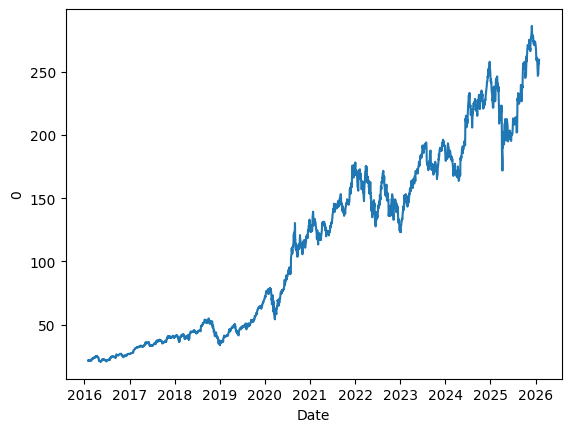

In [10]:
sns.lineplot(df[(df['Ticker'] == 'AAPL') & (df['Price'] == 'Close')],x='Date',y=0);

# Plot the different prices

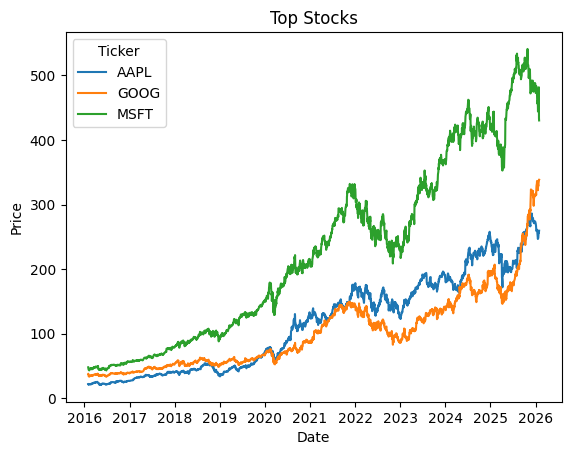

In [11]:
sns.lineplot(df_close, x='Date', y=0, hue='Ticker')
plt.ylabel('Price')
plt.title('Top Stocks');

# Plot their simple moving averages

In [12]:
# Compute 20-day SMA for each Ticker
df_close['sma_20day'] = df_close.groupby('Ticker')[0].transform(lambda x: x.rolling(20).mean())

# Now df_close already has the SMA column; no need to merge

df_close.rename(columns={0:'Close Price'},inplace=True)

df_close.head()

,Price,Ticker,Date,Close Price,sma_20day
0,Close,AAPL,2016-02-01,21.741970,NaN
1,Close,AAPL,2016-02-02,21.302311,NaN
2,Close,AAPL,2016-02-03,21.723930,NaN
3,Close,AAPL,2016-02-04,21.898476,NaN
4,Close,AAPL,2016-02-05,21.313620,NaN


In [13]:
df_close_melt = df_close.melt(id_vars=['Date','Ticker'], value_vars=['Close Price','sma_20day'],var_name='Type', value_name='Price (dollars)')
df_close_melt

,Date,Ticker,Type,Price (dollars)
0,2016-02-01,AAPL,Close Price,21.741970
1,2016-02-02,AAPL,Close Price,21.302311
2,2016-02-03,AAPL,Close Price,21.723930
3,2016-02-04,AAPL,Close Price,21.898476
4,2016-02-05,AAPL,Close Price,21.313620
...,...,...,...,...
15085,2026-01-26,MSFT,sma_20day,471.041000
15086,2026-01-27,MSFT,sma_20day,470.684500
15087,2026-01-28,MSFT,sma_20day,470.411000
15088,2026-01-29,MSFT,sma_20day,467.712000


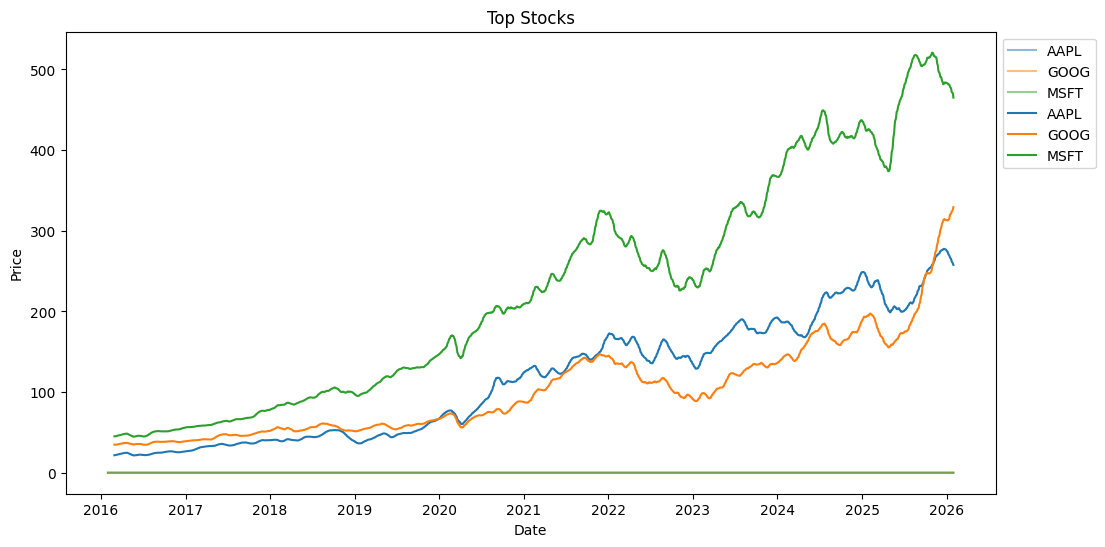

In [14]:
plt.figure(figsize=(12,6))

# Plot actual prices
sns.lineplot(data=df_close, x='Date', y=0, hue='Ticker', alpha=0.5)

# Plot 20-day SMA
sns.lineplot(data=df_close, x='Date', y='sma_20day', hue='Ticker')

plt.ylabel('Price')
plt.title('Top Stocks')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

In [15]:
df_close_melt.head()

,Date,Ticker,Type,Price (dollars)
0,2016-02-01,AAPL,Close Price,21.741970
1,2016-02-02,AAPL,Close Price,21.302311
2,2016-02-03,AAPL,Close Price,21.723930
3,2016-02-04,AAPL,Close Price,21.898476
4,2016-02-05,AAPL,Close Price,21.313620


# Plot the stocks with their 20 day moving average

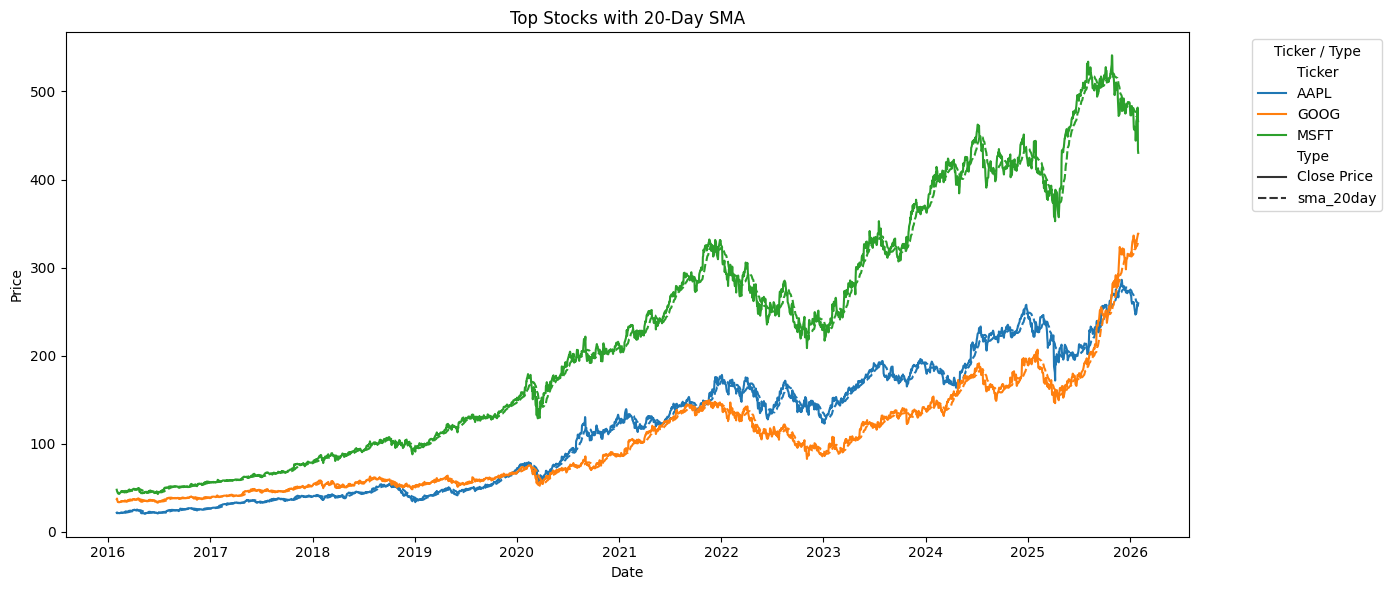

In [16]:
plt.figure(figsize=(14,6))

sns.lineplot(
    data=df_close_melt,
    x='Date',
    y='Price (dollars)',
    hue='Ticker',
    style='Type',   # differentiates Close vs SMA
    palette='tab10'
)

plt.title('Top Stocks with 20-Day SMA')
plt.ylabel('Price')
plt.xlabel('Date')
plt.legend(title='Ticker / Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Predict Apple with Prophet

In [17]:
df_close.Ticker.unique()

array(['AAPL', 'GOOG', 'MSFT'], dtype=object)

In [18]:
# Filter for AAPL
aapl = df_close[df_close['Ticker'] == 'AAPL'][['Date', 'Close Price']].copy()
aapl.rename(columns={'Date': 'ds', 'Close Price': 'y'}, inplace=True)


In [19]:
from prophet import Prophet

# Initialize model
model = Prophet(daily_seasonality=True)
model.fit(aapl)


15:16:48 - cmdstanpy - INFO - Chain [1] start processing
15:16:48 - cmdstanpy - INFO - Chain [1] done processing


ValueError: An error occurred when parsing Stan csv C:\Users\nick\AppData\Local\Temp\tmpb_l_x88f\prophet_modelkucbw8f3\prophet_model-20260201151648.csv